In [27]:
from google.colab import files
uploaded = files.upload()

Saving MSN.csv to MSN.csv


In [28]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [29]:
df = pd.read_csv('MSN.csv')
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df1=df.reset_index()['Price']

In [30]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing, and validation arcording to 7:2:1

In [80]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [81]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [82]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [83]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [84]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [85]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 43ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 2/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0010 - val_loss: 5.4433e-04
Epoch 3/100
13/13 [==============================] - 0s 24ms/step - loss: 7.5472e-04 - val_loss: 5.1135e-04
Epoch 4/100
13/13 [==============================] - 0s 25ms/step - loss: 6.7471e-04 - val_loss: 4.5729e-04
Epoch 5/100
13/13 [==============================] - 0s 24ms/step - loss: 6.5470e-04 - val_loss: 4.1794e-04
Epoch 6/100
13/13 [==============================] - 0s 25ms/step - loss: 6.1601e-04 - val_loss: 3.5769e-04
Epoch 7/100
13/13 [==============================] - 0s 23ms/step - loss: 6.1253e-04 - val_loss: 3.5107e-04
Epoch 8/100
13/13 [==============================] - 0s 25ms/step - loss: 5.8582e-04 - val_loss: 3.4361e-04
Epoch 9/100
13/13 [==============================] - 0s 24ms/step - loss: 5.6652e-04 - val_loss: 3.5085e-04
Epoch 10/100
13/13 [====================

In [86]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 38ms/step


In [87]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [88]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)


Validation RMSE: 1520.2299007979564
Testing RMSE: 1611.0859183167129
Validate MAE:  1179.223538306452
Test MAE:  1236.4541377314815
Validate MAPE:  1.6461665826816634
Test MAPE:  1.6677599856402807


In [89]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape
print(len(val_data))
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


132
[0.37696183]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708

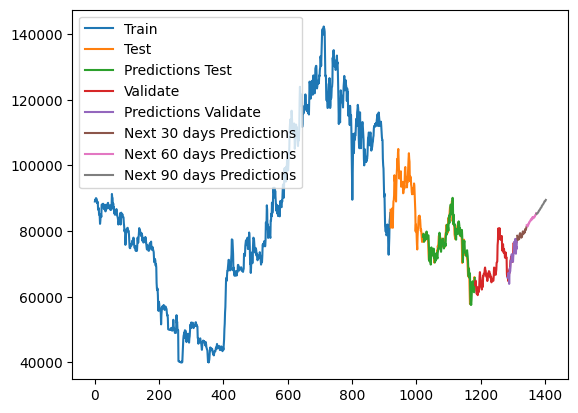

In [90]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()

<h1># 4. Split the data into training, testing, and validation arcording to 5:3:2

In [91]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [92]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [93]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [96]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [97]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [98]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 110ms/step - loss: 0.0947 - val_loss: 0.0539
Epoch 2/100
9/9 [==============================] - 1s 83ms/step - loss: 0.0210 - val_loss: 0.0302
Epoch 3/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 4/100
9/9 [==============================] - 1s 84ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/100
9/9 [==============================] - 0s 53ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 6/100
9/9 [==============================] - 0s 51ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 7/100
9/9 [==============================] - 0s 39ms/step - loss: 9.0925e-04 - val_loss: 0.0018
Epoch 8/100
9/9 [==============================] - 0s 30ms/step - loss: 8.8941e-04 - val_loss: 0.0018
Epoch 9/100
9/9 [==============================] - 0s 27ms/step - loss: 8.5438e-04 - val_loss: 0.0018
Epoch 10/100
9/9 [==============================] - 0s 26ms/step - loss: 8.3044e-04 - val_loss: 0.0017
Ep

In [99]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 7ms/step


In [100]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [101]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 2158.1134797509926
Testing RMSE: 3348.73228626186
Validate MAE:  1641.474884969325
Test MAE:  2474.619667235495
Validate MAPE:  2.4017162339110185
Test MAPE:  2.564313532670471


In [102]:
# 13. Dự báo 90 ngày tiếp theo

x_input=val_data[164:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.3697852]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 0

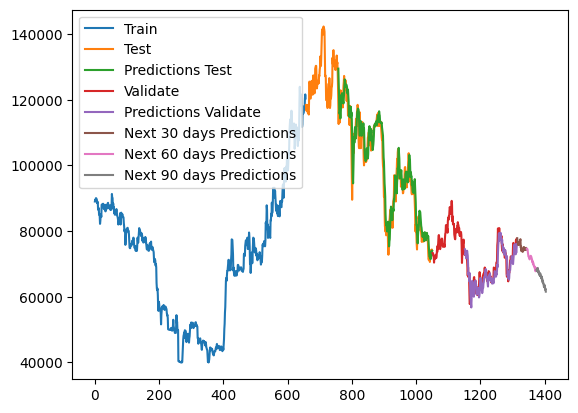

In [103]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+30, stop=len(df1)+60, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+60, stop=len(df1)+90, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()


<h1># 4. Split the data into training, testing, and validation arcording to 6:3:1

In [67]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [68]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [69]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [70]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [71]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [72]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 50ms/step - loss: 0.1608 - val_loss: 0.0238
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 3/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 4/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 5/100
11/11 [==============================] - 0s 45ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 6/100
11/11 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 7/100
11/11 [==============================] - 1s 50ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 8/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 9/100
11/11 [==============================] - 1s 56ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 10/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 0.0063

In [73]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 44ms/step


In [74]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [75]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 2459.6444985518287
Testing RMSE: 3103.766757140264
Validate MAE:  2063.014112903226
Test MAE:  2316.2427741040956
Validate MAPE:  2.856375870246704
Test MAPE:  2.842885926884795


In [77]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1



[0.37316763]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 

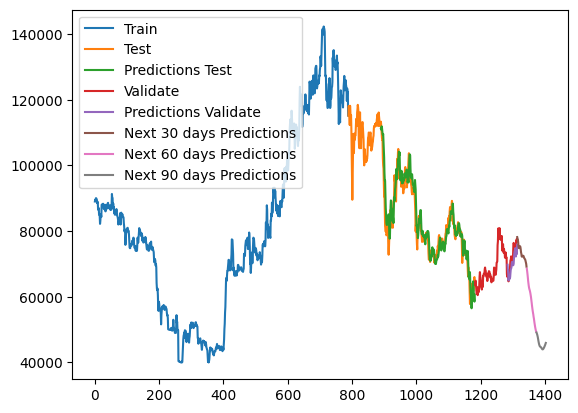

In [79]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()